# Variational Autoencoders in JAX

This notebook shows how to build a deep Variational Autoencoder (VAE) with JAX, trained on the MNIST dataset. The implementation is inspired by a lecture about generative ML at the University of Toronto.

A VAE is a kind of autoencoder that outputs a probability distribution in the latent space, unlike their (unvariational) counterpart that outputs a single latent vector instead. Our VAE encoder, instead of learning a good encoding vector in the latent space, gives the parameters of a multidimensional isotropic Gaussian that can be used to sample encodings from the latent space.

A quick recap on the inner workings. For an input $x_i$ and it's low-dimensional, latent representation $z$ we approximate the true posterior $p(z \vert x_i) \approx q_{\Phi_i}(z \vert x_i) = \mathcal{N}(\mu_i, \sigma_i^2)$ by a multidimensional isotropic Gaussian parametrized by $\Phi_i = (\mu_i, \log \sigma_i)$. This is our encoder. We decode a latent representation $p_\theta(x \vert z)$ parameterized by $\theta$.

Ideally, we would train the network as to maximize the data log probability $\log p(x)$. This is of course intractable; hence maximizing the Evidence Lower Bound (ELBO) serves as our objective placebo. Minimizing the negative ELBO, we get as a loss function:
\begin{align}
\mathcal{L}(\Phi, \theta; x) = -\mathbb{E}_{z \sim q_{\Phi}}{\left [\log p_\theta(x \vert z) \right ]} + KL \left( q_\Phi(z \vert x) \vert \vert p(z) \right)
\end{align}
where the second term denotes our divergence of the assumed Gaussian $q_\Phi$ from the true prior $p(z)$.

Now let's define the model we use for MNIST encoding. Our prior $p(z) = \mathcal{N}(0, I)$ is assumed to be standard Gaussian. The likelihood $p_\theta(x \vert z) = \text{Bernoulli}(\theta)$ will be a multidimensional binomial where we have a bernoulli parameter for each pixel. The posterior approximation $q_{\Phi_i}(z \vert x_i) = \mathcal{N}(\mu_i, \sigma_i^2I)$ is an isotropic Gaussian.

Now in the classic implementation of a VAE, we have a set of parameters $\Phi_i$ for each datapoint, creating a dependency of the number of parameters to the training data size. To circumvent this, we use Amortized Inference (AI) to reduce the number of model parameters. The idea of AI is that instead of having $\Phi_i$ for each datapoint, we have a single $\Phi$ that specifies the parameters of a Neural Networks that, given $x_i$, outputs us $\Phi_i$. So we get $q_{\Phi_i}(z \vert x_i) = \mathcal{N}(z \vert \mu_{\Phi}(x_i), \Sigma_{\Phi}(x_i))$ instead.

JAX will provide us with the necessary autodiff functionality; we use Adam for gradient-based optimization of $\theta$ and $\Phi$.

## Part 1: Preparations

Let us import the necessary packages first.

In [1]:
!pip install --upgrade -q pip jax jaxlib   # JAX
!pip install git+https://github.com/google/flax.git   # Flax
!pip install git+https://github.com/deepmind/optax.git # Optax

from jax import jit, grad, value_and_grad, lax, vmap, random
import jax.numpy as np
import jax.random
from jax.scipy.special import logsumexp
from jax.scipy.stats import norm
from jax.tree_util import register_pytree_node

from flax import linen as nn
import optax

import tensorflow_probability as tfp
import tensorflow_probability.substrates.jax.distributions as dists

from jax.config import config 
config.update("jax_debug_nans", True)

import matplotlib.pyplot as plt
from tqdm.auto import trange
from functools import partial
from random import randint   # simple python rnd

     |████████████████████████████████| 2.0 MB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/google/flax.git to /tmp/pip-req-build-2qfvifc6
  Running command git clone --filter=blob:none --quiet https://github.com/google/flax.git /tmp/pip-req-build-2qfvifc6
  Resolved https://github.com/google/flax.git to commit 45c29559f9c105a6d7e97d218d8557f8c1600716
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 12.0 MB/s eta 0:00:00
  Created wheel for flax: filename=flax-0.6.0-py3-none-any.whl size=184748 sha256=a0d815b9f6e9d6a2f56d18e9ad1e08d1ad3454589a63c6368cee6d21692f6359
  Stored in directory: /tmp/pip-ephem-whee

## Part 2: Data
First things first, get the data!

Each datapoint in the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) is a 28x28 grayscale image (i.e. pixels are values between 0 and 1) of a handwritten digit in $\{0 \dots 9\}$, and a label indicating which number.

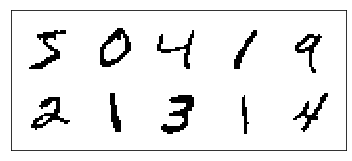

In [2]:
# Load MNIST data
import os
import gzip
import struct
import array
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)

def mnist():
    base_url = 'http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images[:1000], test_labels[:1000]

def load_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(np.array(x.shape[1:]))))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

N_data, train_images, train_labels, test_images, test_labels = load_mnist()

import numpy as onp   # original numpy
def plot_images(images, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = onp.int32(onp.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = onp.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(onp.array([]))
        plt.yticks(onp.array([]))
    
    plt.plot()

plot_images(train_images[:10, :])

## Part 3: Implement the VAE
Now that we have everything we need, we implement the Variational Autoencoder on binarized MNIST digits, as introduced by the paper [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf) by Kingma and Welling (2013). 

At first, some generic VAE funtions:

In [3]:
# Generic VAE functions.

def log_prior(z): 
    return np.sum(norm.logpdf(z, 0.0, 1.0), axis=-1)

def diag_gaussian_sample(rng, mean, log_std): 
  return mean + np.exp(log_std) * random.normal(rng, mean.shape) # single sample from a diagonal multivariate Gaussian

def diag_gaussian_logpdf(x, mean, log_std):
  return np.sum(vmap(norm.logpdf)(x, mean, np.exp(log_std))) # evaluate a single point on a diagonal multivariate Gaussian

def elbo(  # Single-sample Monte Carlo estimate of the variational lower bound.
    recognition_net,    # takes recognition_params and a datapoint, outputs mean and log_std of size latent_dim, i.e. log q(z|x)
    log_joint,          # takes likelihood_params and a vector of size latent_dim and a datapoint, outputs unnormalized log joint, i.e. log p(x,z)
    recognition_params, # Phi
    model_params,       # theta
    datapoint, rng):

  q_params = recognition_net(recognition_params, datapoint)  # get the approximate posterior parameters for dp using amotized inference
  mu, log_standarddev = q_params
  sample = diag_gaussian_sample(rng, mean=mu, log_std=log_standarddev)  # sample from approximate posterior.
  log_joint_value = log_joint(model_params, sample, datapoint) 
  log_post_value = diag_gaussian_logpdf(sample, mean=mu, log_std=log_standarddev) # Evaluates the density of log posterior q(z).
  
  # KL-divergence between two multidim. Gaussians
  d_kl = 0.5*(np.sum(np.exp(log_standarddev)) + np.dot(mu, mu) - datapoint.shape[0] - np.sum(log_standarddev)) 
  elbo_hat = log_joint_value - d_kl 
  return elbo_hat

def batch_elbo(recognition_net, log_joint, recognition_params, model_params, data, rng):   # batched version using JAX's vmap
  batch_size = data.shape[0]
  rngs = random.split(rng, batch_size)
  vectorized_elbo = vmap(partial(elbo, recognition_net, log_joint,
                                 recognition_params, model_params),
                         in_axes=(0, 0))
  return np.mean(vectorized_elbo(data, rngs)) # average ELBO estimate over a batch of samples


Here we set the dimension of the latent space to 2.
A larger latent dimension would provide a more powerful model, but a dimension of two will make visualization and debugging easier.

Given the latent representation $z$ for an image, the distribution over all 784 pixels in the image is given by a product of independent Bernoullis, whose means are given by the output of a neural network $f_\theta(z)$:
$$p(x|z, \theta) = \prod_{d=1}^{784} \operatorname{Ber}(x_d|f_\theta(z)_d)$$
The neural network $f_\theta$ is called the decoder, and its parameters $\theta$ will be optimized to fit the data.

After each hundert iterations, we report the Evidence Lower Bound. 

In [18]:
# Define a VAE for the MNIST dataset

data_dimension = 28*28
latent_dimension = 2
key = random.PRNGKey(0)

class RecognitionNet(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=150)(x)
    x = nn.relu(x)
    x = nn.Dense(features=100)(x)
    x = nn.relu(x)
    mean = nn.Dense(features=latent_dimension)(x)   # Output mean of q(z)
    log_std = nn.Dense(features=latent_dimension)(x)   # Output log_std of q(z)
    return mean, log_std

class Decoder(nn.Module):
  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=150)(x)
    x = nn.relu(x)
    x = nn.Dense(features=100)(x)
    x = nn.relu(x)
    x = nn.Dense(features=data_dimension)(x)   # Output logit of Ber(x|z)
    return x

x_rand = random.normal(key, (data_dimension,))
z_rand = random.normal(key, (latent_dimension,))
init_recognition_params = RecognitionNet().init(key, x_rand)
init_decoder_params = Decoder().init(key, z_rand)

# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
  return -np.sum(np.logaddexp(0., np.where(x, -1., 1.) * logits))   # Bernoulli log pdf of data x given logits

def log_likelihood(decoder_params, latent, datapoint):
  logits = Decoder().apply(decoder_params, latent)
  return bernoulli_logpdf(logits, datapoint)

def log_joint(decoder_params, latent, datapoint):
  return log_likelihood(decoder_params, latent, datapoint) + log_prior(latent)

# Run optimization
n_iters = 6000
minibatch_size = 200
optimizer = optax.adam(learning_rate=1e-3)
params = (init_recognition_params, init_decoder_params)
opt_state = optimizer.init(params)

@jax.jit
def objective(params, t):  # The loss function to be minimized.  
  rng = random.PRNGKey(t)
  minibatch_ixs = random.choice(key, train_images.shape[0], (minibatch_size,))
  minibatch =  train_images[minibatch_ixs, :]
  recognition_params, decoder_params = params
  return -batch_elbo(RecognitionNet().apply, log_joint, recognition_params, decoder_params, minibatch, rng) 
  
def callback(params, t):
  if t % 100 == 0:
    print(f"Iteration {t}: ELBO {-objective(params, t)}")
  
@jax.jit
def step(params, opt_state, rnd):   
    gradient = grad(objective)(params, rnd)  # rnd used for random key in objective
    updates, opt_state = optimizer.update(gradient, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    params, opt_state = step(params, opt_state, t)
    callback(params, t)

recognition_params, decoder_params = params

Optimizing variational parameters...


  0%|          | 0/6000 [00:00<?, ?it/s]

Iteration 0: ELBO -156.91616821289062
Iteration 100: ELBO 201.55059814453125
Iteration 200: ELBO 215.46490478515625
Iteration 300: ELBO 227.02999877929688
Iteration 400: ELBO 236.34043884277344
Iteration 500: ELBO 243.4761505126953
Iteration 600: ELBO 250.57537841796875
Iteration 700: ELBO 255.8446502685547
Iteration 800: ELBO 260.34552001953125
Iteration 900: ELBO 264.0634765625
Iteration 1000: ELBO 266.9068908691406
Iteration 1100: ELBO 269.82440185546875
Iteration 1200: ELBO 271.3938293457031
Iteration 1300: ELBO 274.3059997558594
Iteration 1400: ELBO 276.95477294921875
Iteration 1500: ELBO 279.1895751953125
Iteration 1600: ELBO 281.1866455078125
Iteration 1700: ELBO 282.7423400878906
Iteration 1800: ELBO 284.7330322265625
Iteration 1900: ELBO 286.1210021972656
Iteration 2000: ELBO 288.1435546875
Iteration 2100: ELBO 289.70806884765625
Iteration 2200: ELBO 291.39703369140625
Iteration 2300: ELBO 292.6307678222656
Iteration 2400: ELBO 294.3102722167969
Iteration 2500: ELBO 295.528991

## Part 4: Investigate the Model

Great, model implementation and training has been completed! In what follows, we investigate our model by visualizing the distribution over data given by the generative model, sampling from it, and interpolating between digits.

One way to understand the meaning of latent representations is to see which parts of the latent space correspond to which kinds of data. Here we'll produce a scatter plot in the latent space, where each point in the plot represents a different image in the training set.

What we do here:

1.   Encode each image in the training set.
2.   Take the 2D mean vector of each encoding $q_\phi(z|x)$.
3.   Plot these mean vectors in the 2D latent space with a scatterplot.
4.   Colour each point according to the class label (0 to 9).


Hopefully our latent space will group images of different classes, even though we never provided class labels to the model. The latent structure has been learned by the model!





(-4.632243609428405, 5.384226775169372, -4.720753169059753, 4.777469611167907)

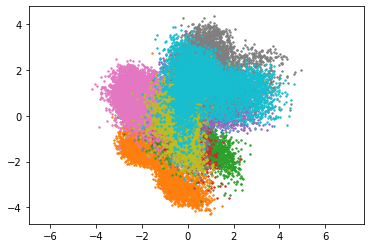

In [19]:
for k in range(10):
  cur_data = train_images[train_labels[:, k] == True, :]
  latent_mean, _ = RecognitionNet().apply(recognition_params, cur_data)
  plt.scatter(latent_mean[:, 0], latent_mean[:, 1], s=2)

plt.axis("equal")

But we can do more than that. A VAE is a generative model. We will generate some images by sampling from the prior in the latent space and decoding them to obtain artificial MNIST images.

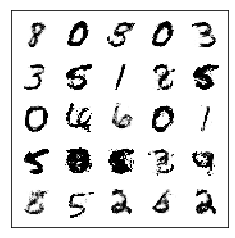

In [20]:
# Sample data from the trained generative model to see if it roughly matches the data.

def sigmoid(x):
  return 0.5 * (np.tanh(x) + 1.0)

recognition_params, decoder_params = params
n_samples = 25
sampled_zs = jax.random.normal(key, shape=(n_samples,latent_dimension)) # sample from prior on z.
vdecoder = vmap(Decoder().apply, in_axes=(None, 0))
bernoulli_means = sigmoid(vdecoder(decoder_params, sampled_zs)) # call decoder, and map logits to probabilities.
plot_images(bernoulli_means)

Another interesting way to examine a continuous latent variable model is to interpolate between the latent representations of two points. Here we will encode 3 pairs of data points with different classes. Then we will linearly interpolate between the mean vectors of their latent representation. We will plot the generative distributions along the linear interpolation.


1.   We write a function which takes two points $z_a$ and $z_b$, and a value $\alpha \in [0,1]$, and outputs the linear interpolation $z_\alpha = \alpha z_a + (1-\alpha)z_b$.
2.  Then we sample 3 pairs of images, each having a different class.
3.  Afterwards we encode the images in each pair, take the mean vectors and linearly interpolate them
4.  At 10 equally-space points along the interpolation, we show the Bernoulli means $p(x|z_\alpha)$.

In [21]:
def plot_interp(ix1, ix2):
  left_z = RecognitionNet().apply(recognition_params, train_images[ix1, :])[0]
  right_z = RecognitionNet().apply(recognition_params, train_images[ix2, :])[0]
  interp_weights = list(np.linspace(0.0, 1.0, 10))
  interp_zs = np.array([weight*left_z + (1.0-weight)*right_z for weight in interp_weights])  # Linearly interpolate between left_z and right_z
  bernoulli_means = sigmoid(Decoder().apply(decoder_params, interp_zs))
  plot_images(bernoulli_means)

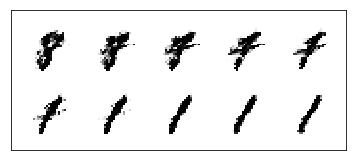

In [22]:
plot_interp(3, 11)

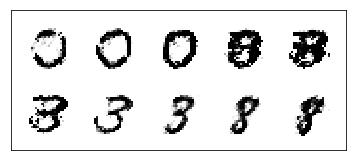

In [23]:
plot_interp(11, 22)

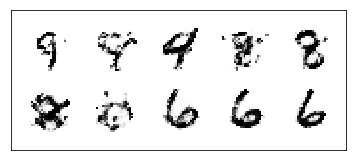

In [25]:
plot_interp(32, 334)

## Part 5: Predicting the Bottom of Images given the Top

Now we'll use the trained generative model to perform inference for $p(z|\text{top half of image x})$.
Unfortunately, we can't re-use our recognition network, since it can only input entire images.
However, we can still do approximate inference without the encoder.

To illustrate this, we'll approximately infer the distribution over the pixels in the bottom half of an image conditioned on the top half of the image:
$$p(\text{bottom half of image x} | \text{top half of image x}) = \int p(\text{bottom half of image x} | z) p( z | \text{top half of image x}) dz$$
To approximate the posterior $p( z | \text{top half of image x})$, we'll use stochastic variational inference. We implement the SVI:

* Using as variational distribution $q_\phi(z|\text{top half of $x$})$ with parameters $\phi_\mu$ and $\phi_{\log \sigma}$ the family of multidim. Gaussians
* Optimizing $\phi_\mu$ and $\phi_{\log \sigma}$ with SGD as to maximize the ELBO. We estimate the ELBO averaging over $K$ samples $z \sim q_\phi(z|\text{top half of $x$})$ using the values $\log p(z)$, $\log p(\text{top half of $x$} | z)$, and $\log q_\phi(z|\text{top half of $x$})$.

Finally, we take a sample $z$ from the approximate posterior and feed it to the decoder to find the Bernoulli means of $p( \text{bottom half of image x}|z)$.  Concatenating this greyscale image to the true top of the image, we output the predicted image completion.

In [29]:
def firsthalf(x):
  D = np.shape(x)[-1]
  return x[:(D // 2)]

def secondhalf(x):
  D = np.shape(x)[-1]
  return x[(D // 2):]

# Set up optimizer.
num_samples_per_iter = 50

def infer_bottom_half(ix):
  datapoint = train_images[ix, :]

  def log_likelihood_half(latent):
    logits = Decoder().apply(decoder_params, latent)
    return np.sum(dists.Bernoulli(logits=firsthalf(logits)).log_prob(firsthalf(datapoint))) # compute log probability of p(first half of image | z)

  def log_joint_half(latent):
    return log_likelihood_half(latent) + log_prior(latent) # compute log probability of p(first half of image, z)

  def svi_elbo(logprob, rng, mean, log_std):
    # Single-sample Monte Carlo estimate of the variational lower bound.
    sample = diag_gaussian_sample(rng, mean, log_std)
    return logprob(sample) - diag_gaussian_logpdf(sample, mean, log_std)

  def batch_svi_elbo(logprob, rng, params, num_samples):
    # Average over a batch of random samples. Use the vmap function for this part.
    rngs = random.split(rng, num_samples)
    vectorized_elbo = vmap(partial(svi_elbo, logprob), in_axes=(0, None, None))
    return np.mean(vectorized_elbo(rngs, *params))

  # Run optimization
  @jax.jit
  def svi_objective(params, t):   # The loss function to be minimized.
    rng = random.PRNGKey(t)
    return -batch_svi_elbo(log_joint_half, rng, params, num_samples_per_iter)

  n_iters = 200
  init_mean = np.zeros(latent_dimension)   # variational parameter mean
  init_std  = np.zeros(latent_dimension)   # variational parameter std
  svi_params = (init_mean, init_std)
  optimizer = optax.sgd(learning_rate=1e-3, momentum=0.9)
  opt_state = optimizer.init(svi_params)
  
  def svi_callback(svi_params, t):
    if t % 10 == 0:
      print(f"Iteration {t}: objective {svi_objective(svi_params, t)}")
    
  @jax.jit
  def step(params, opt_state, rnd):   
      gradient = grad(svi_objective)(params, rnd)  # rnd used for random key in objective
      updates, opt_state = optimizer.update(gradient, opt_state)
      params = optax.apply_updates(params, updates)
      return params, opt_state

  print("Optimizing SVI parameters...")
  for t in trange(0, n_iters):
      svi_params, opt_state = step(svi_params, opt_state, t)
      svi_callback(svi_params, t)

  (svi_mean, adsf) = svi_params

  # Plotting code.
  tophalf = np.concatenate([firsthalf(datapoint), 0.*firsthalf(datapoint)])
  decoded = sigmoid(Decoder().apply(decoder_params, svi_mean))   # decode the optimized svi mean to get the bottom prediction
  combined = np.concatenate([firsthalf(datapoint), secondhalf(decoded)]) # build mnist image
  all = np.stack([datapoint, tophalf, combined], axis=1)
  plot_images(all.T)

Optimizing SVI parameters...


  0%|          | 0/200 [00:00<?, ?it/s]

Iteration 0: objective 537.3950805664062
Iteration 10: objective 1016.8563842773438
Iteration 20: objective 472.00732421875
Iteration 30: objective 890.9573364257812
Iteration 40: objective 692.2160034179688
Iteration 50: objective 511.19091796875
Iteration 60: objective 85.89325714111328
Iteration 70: objective 247.76976013183594
Iteration 80: objective 700.8286743164062
Iteration 90: objective 1153.2003173828125
Iteration 100: objective 1427.7265625
Iteration 110: objective 1888.7808837890625
Iteration 120: objective 1339.872314453125
Iteration 130: objective 1390.5440673828125
Iteration 140: objective 2446.279052734375
Iteration 150: objective 2249.667724609375
Iteration 160: objective 209.14373779296875
Iteration 170: objective 1326.8438720703125
Iteration 180: objective 157.42543029785156
Iteration 190: objective 694.534912109375


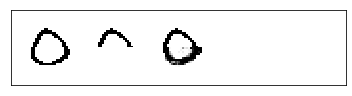

In [39]:
rnd_ix = randint(0, train_images.shape[0])
infer_bottom_half(rnd_ix)